In [17]:
# create a training job for baselines
import boto3
import pprint as pp

s = boto3.Session(profile_name='default')

ecr = boto3.Session(profile_name='default').client('ecr')

In [18]:
ecr.delete_repository(
    repositoryName='openai-baselines',
    force=True
)


RepositoryNotFoundException: An error occurred (RepositoryNotFoundException) when calling the DeleteRepository operation: The repository with name 'openai-baselines' does not exist in the registry with id '688520471316'

In [7]:
try:
    # The repository might already exist
    # in your ECR
    cr_res = ecr.create_repository(
        repositoryName='baselines-sagemaker')
except Exception as e:
    print(e)

An error occurred (RepositoryAlreadyExistsException) when calling the CreateRepository operation: The repository with name 'baselines-sagemaker' already exists in the registry with id '688520471316'


In [ ]:
# push the image to ecr

In [52]:
%%bash
account=$(aws sts get-caller-identity --query Account | sed -e 's/^"//' -e 's/"$//')
region=$(aws configure get region)
ecr_account=${account}.dkr.ecr.${region}.amazonaws.com

# Give docker your ECR login password
aws ecr get-login-password --region $region | docker login --username AWS --password-stdin $ecr_account

# Fullname of the repo
fullname=$ecr_account/baselines-sagemaker:latest

#echo $fullname
# Tag the image with the fullname
docker tag baselines-sagemaker:latest $fullname

# Push to ECR
docker push $fullname

Login Succeeded
The push refers to repository [688520471316.dkr.ecr.us-west-2.amazonaws.com/baselines-sagemaker]
bf3edd56cbae: Preparing
bf3edd56cbae: Preparing
d545f6d7428a: Preparing
e0b8f78ef1a1: Preparing
e4e6810f2be6: Preparing
08e864052143: Preparing
183c6b93ae58: Preparing
097e070097db: Preparing
e95ae1c1e1a8: Preparing
e43210c84711: Preparing
74dfe3df0c94: Preparing
8e29486d090c: Preparing
76bfe8e7e45c: Preparing
3779360d2582: Preparing
9f10818f1f96: Preparing
27502392e386: Preparing
c95d2191d777: Preparing
183c6b93ae58: Waiting
76bfe8e7e45c: Waiting
3779360d2582: Waiting
097e070097db: Waiting
9f10818f1f96: Waiting
e95ae1c1e1a8: Waiting
27502392e386: Waiting
e43210c84711: Waiting
c95d2191d777: Waiting
74dfe3df0c94: Waiting
8e29486d090c: Waiting
08e864052143: Layer already exists
e0b8f78ef1a1: Layer already exists
e4e6810f2be6: Layer already exists
183c6b93ae58: Layer already exists
097e070097db: Layer already exists
e95ae1c1e1a8: Layer already exists
74dfe3df0c94: Layer already

WARNING! Your password will be stored unencrypted in /home/ubuntu/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store



In [19]:
# Inspect the ECR repository
repo_res = ecr.describe_images(
    repositoryName='baselines-sagemaker')
pp.pprint(repo_res)

{'ResponseMetadata': {'HTTPHeaders': {'content-length': '406',
                                      'content-type': 'application/x-amz-json-1.1',
                                      'date': 'Sun, 09 May 2021 22:37:05 GMT',
                                      'x-amzn-requestid': 'bafacee0-532f-4d36-96bf-d6eb7ca9d95e'},
                      'HTTPStatusCode': 200,
                      'RequestId': 'bafacee0-532f-4d36-96bf-d6eb7ca9d95e',
                      'RetryAttempts': 0},
 'imageDetails': [{'artifactMediaType': 'application/vnd.docker.container.image.v1+json',
                   'imageDigest': 'sha256:2aa43fd475b10f97af6133dad77e8d037d7b5eb4b1fcb477bc923612d7c3c3a7',
                   'imageManifestMediaType': 'application/vnd.docker.distribution.manifest.v2+json',
                   'imagePushedAt': datetime.datetime(2021, 5, 9, 22, 35, 18, tzinfo=tzlocal()),
                   'imageSizeInBytes': 945067249,
                   'imageTags': ['latest'],
                   'r

In [19]:
import boto3 # your gateway to AWS APIs
import datetime
import pprint
import os
import time
import re

def current_time():
    ct = datetime.datetime.now() 
    return str(ct.now()).replace(":", "-").replace(" ", "-")[:19]


def account_id():
    return boto3.client('sts').get_caller_identity()['Account']

In [53]:

sm_boto3 = boto3.client('sagemaker')

# name training job
training_job_name = f'trpo-pendulum-{current_time()}'

output_path = "s3://hongshan-sagemaker-experiments/trpo/trpo"

# exec role
role = "arn:aws:iam::688520471316:role/RL"


# ECR URI of your image
region = boto3.Session().region_name
account = account_id()
image_uri = f"{account}.dkr.ecr.{region}.amazonaws.com/baselines-sagemaker:latest"


algorithm_specification = {
    "TrainingImage": image_uri,
    "TrainingInputMode": 'File'
}

hyperparameters = {
    "num_timesteps": "1e4",
    "timesteps_per_batch": "512"
}

output_data_config = {
    'S3OutputPath': output_path
}

resource_config = {
    'InstanceType': 'ml.m5.large',
    'InstanceCount':1,
    'VolumeSizeInGB':10
}


stopping_condition={
    'MaxRuntimeInSeconds':1200,
}

In [23]:
help(sm_boto3.create_training_job)

Help on method create_training_job in module botocore.client:

create_training_job(*args, **kwargs) method of botocore.client.SageMaker instance
    Starts a model training job. After training completes, Amazon SageMaker saves the resulting model artifacts to an Amazon S3 location that you specify. 
    
     
    
    If you choose to host your model using Amazon SageMaker hosting services, you can use the resulting model artifacts as part of the model. You can also use the artifacts in a machine learning service other than Amazon SageMaker, provided that you know how to use them for inference. 
    
     
    
    In the request body, you provide the following: 
    
     
    
     
    * ``AlgorithmSpecification`` - Identifies the training algorithm to use.  
     
    * ``HyperParameters`` - Specify these algorithm-specific parameters to enable the estimation of model parameters during training. Hyperparameters can be tuned to optimize this learning process. For a list of hyperpar

In [54]:
ct_res = sm_boto3.create_training_job(
    TrainingJobName=training_job_name,
    AlgorithmSpecification=algorithm_specification,
    HyperParameters=hyperparameters,
    RoleArn=role,
    OutputDataConfig=output_data_config,
    ResourceConfig=resource_config,
    StoppingCondition=stopping_condition
)

In [55]:
# check training job status every 30 seconds
stopped = False
while not stopped:
    tj_state = sm_boto3.describe_training_job(
        TrainingJobName=training_job_name)
    if tj_state['TrainingJobStatus'] in ['Completed', 'Stopped', 'Failed']:
        stopped=True
    else:
        print("Training in progress")
        time.sleep(30)

if tj_state['TrainingJobStatus'] == 'Failed':
    print("Training job failed ")
    print("Failed Reason: {}".format(tj_state['FailedReason']))
else:
    print("Training job completed")
    

Training in progress
Training in progress
Training in progress
Training in progress
Training in progress
Training in progress
Training in progress
Training in progress
Training job completed


In [77]:
!aws s3 ls s3://hongshan-sagemaker-experiments/trpo/cartpole/trpo-pendulum-2021-05-10-00-43-31/output/

2021-05-10 00:47:29      38461 model.tar.gz


In [78]:
!aws s3 cp s3://hongshan-sagemaker-experiments/trpo/cartpole/trpo-pendulum-2021-05-10-00-43-31/output/model.tar.gz .

download: s3://hongshan-sagemaker-experiments/trpo/cartpole/trpo-pendulum-2021-05-10-00-43-31/output/model.tar.gz to ./model.tar.gz


In [79]:
!tar -xzvf model.tar.gz -C model

ckpt/
ckpt/ckpt-1.index
ckpt/checkpoint
ckpt/ckpt-1.data-00000-of-00001
output/
output/log.txt
output/0.0.monitor.csv
output/progress.csv


## Create a list of experiments with different hyperparameters

In [28]:
# train same number of iterations
# say update the model 1e6 times
# so if a batch size is x
# then total timesteps would be x * 1e6

n_iters = 1e5
expts = []

hyperparameters = {
    "num_timesteps": "1e4",
    "timesteps_per_batch": "512"
}

base = 4 # basecase 4 steps per batch

for i in range(1, 7):
    num_timesteps = n_iters * 4 * 2**i
    expts.append(
        {
            "num_timesteps": str(num_timesteps),
            "timesteps_per_batch": str(4*2**i)
        }
    )
    

def get_training_job_name(e):
    return f"trpo-pendulum-{e['timesteps_per_batch']}-{current_time()}"


for e in expts:
    print(get_training_job_name(e))

trpo-pendulum-8-2021-05-10-18-03-43
trpo-pendulum-16-2021-05-10-18-03-43
trpo-pendulum-32-2021-05-10-18-03-43
trpo-pendulum-64-2021-05-10-18-03-43
trpo-pendulum-128-2021-05-10-18-03-43
trpo-pendulum-256-2021-05-10-18-03-43


In [6]:

sm_boto3 = boto3.client('sagemaker')

for e in expts:
    
    training_job_name = get_training_job_name(e)
    print('training job:', training_job_name)

    output_path = "s3://hongshan-sagemaker-experiments/trpo/pendulum"

    # exec role
    role = "arn:aws:iam::688520471316:role/RL"


    # ECR URI of your image
    region = boto3.Session().region_name
    account = account_id()
    image_uri = f"{account}.dkr.ecr.{region}.amazonaws.com/baselines-sagemaker:latest"


    algorithm_specification = {
        "TrainingImage": image_uri,
        "TrainingInputMode": 'File'
    }

    hyperparameters = e

    output_data_config = {
        'S3OutputPath': output_path
    }

    resource_config = {
        'InstanceType': 'ml.m5.large',
        'InstanceCount':1,
        'VolumeSizeInGB':10
    }


    stopping_condition={
        'MaxRuntimeInSeconds':60*60*24,
    }
    
    # call CreateTrainingJob
    ct_res = sm_boto3.create_training_job(
    TrainingJobName=training_job_name,
    AlgorithmSpecification=algorithm_specification,
    HyperParameters=hyperparameters,
    RoleArn=role,
    OutputDataConfig=output_data_config,
    ResourceConfig=resource_config,
    StoppingCondition=stopping_condition
    )
    
    
    

training job: trpo-pendulum-8-2021-05-10-01-28-32
training job: trpo-pendulum-16-2021-05-10-01-28-32
training job: trpo-pendulum-32-2021-05-10-01-28-34
training job: trpo-pendulum-64-2021-05-10-01-28-35
training job: trpo-pendulum-128-2021-05-10-01-28-36
training job: trpo-pendulum-256-2021-05-10-01-28-37


In [7]:
# get log streams

logs = boto3.client('logs')


def print_logs(training_job_name):
    log_res= logs.describe_log_streams(
        logGroupName='/aws/sagemaker/TrainingJobs',
        logStreamNamePrefix=training_job_name)

    for log_stream in log_res['logStreams']:
        # get one log event
        log_event = logs.get_log_events(
            logGroupName='/aws/sagemaker/TrainingJobs',
            logStreamName=log_stream['logStreamName'])

        # print out messages from the log event
        for ev in log_event['events']:
            for k, v in ev.items():
                if k == 'message':
                    print(v)
                    
    return


In [9]:
print_logs(get_training_job_name(expts[1]))

In [25]:
import os
import re
import tarfile

sm_boto3 = boto3.Session(profile_name='default').client('sagemaker')
s3 = boto3.Session(profile_name='default').client('s3')

def create_artifact_dir(training_job_name):
    artifact_dir = os.path.join(os.environ['HOME'], 'log', training_job_name)
    if not os.path.exists(artifact_dir):
        os.makedirs(artifact_dir)
    return artifact_dir

def inspect_artifact_dir(artifact_dir):
    """Look at what's in the artifact dir"""
    for dp, dirn, fname in os.walk(artifact_dir):
        print(dp, dirn, fname)
    return

def download_artifact(training_job_name):
    """
    Return: path to the downloaded artifact
    """
    tj= sm_boto3.describe_training_job(TrainingJobName=training_job_name)
    if tj['TrainingJobStatus']!='Completed':
        raise "Training job is not completed"
        
    art_uri = tj['ModelArtifacts']['S3ModelArtifacts']
    art_uri = re.sub('s3://', '', art_uri)
    
    bucket, *key = art_uri.split('/')
    key = '/'.join(key)
    
    # get object from s3
    objbody = s3.get_object(Bucket=bucket, Key=key)['Body']
    
    artifact_dir = create_artifact_dir(training_job_name)
    artifact_path = os.path.join(artifact_dir, 'model.tar.gz')
    with open(artifact_path, 'wb') as f:
        f.write(objbody.read())
        
    # untar artifact
    tar = tarfile.open(artifact_path, "r:gz")
    tar.extractall(artifact_dir)
    
    print('==== Walking the artifact dir ====')
    inspect_artifact_dir(artifact_dir)
    return artifact_dir


In [26]:
download_artifact("trpo-pendulum-8-2021-05-10-01-28-32")

==== Walking the artifact dir ====
/home/ubuntu/log/trpo-pendulum-8-2021-05-10-01-28-32 ['ckpt', 'output'] ['model.tar.gz']
/home/ubuntu/log/trpo-pendulum-8-2021-05-10-01-28-32/ckpt [] ['ckpt-1.data-00000-of-00001', 'checkpoint', 'ckpt-1.index']
/home/ubuntu/log/trpo-pendulum-8-2021-05-10-01-28-32/output [] ['log.txt', 'progress.csv', '0.0.monitor.csv']


'/home/ubuntu/log/trpo-pendulum-8-2021-05-10-01-28-32'

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

def get_performance(training_job_name):
    """Look at the moving average of episode reward"""
    artifact_dir = os.path.join(os.environ['HOME'], 'log', training_job_name)
    progress = os.path.join(artifact_dir, 'output', 'progress.csv')
    
    progress = pd.read_csv(progress).dropna()
    print(progress.head())
    return progress

In [69]:
p = get_performance("trpo-pendulum-8-2021-05-10-01-28-32")

    EpLenMean  EpRewMean  EpThisIter  EpisodesSoFar  TimeElapsed  \
24      200.0 -22.055405           1              1     2.151865   
25      200.0 -22.055405           0              1     2.177904   
26      200.0 -22.055405           0              1     2.207538   
27      200.0 -22.055405           0              1     2.233432   
28      200.0 -22.055405           0              1     2.262028   

    TimestepsSoFar  entloss   entropy  ev_tdlam_before    meankl  optimgain  \
24             200      0.0  1.356276        -0.017681  0.000598   0.006871   
25             200      0.0  1.352570        -0.200424  0.001086   0.034623   
26             200      0.0  1.351610         0.006587  0.000916   0.009734   
27             200      0.0  1.356824        -0.102654  0.000419   0.022545   
28             200      0.0  1.350048        -0.017932  0.000370   0.010599   

    surrgain  
24  0.006871  
25  0.034623  
26  0.009734  
27  0.022545  
28  0.010599  


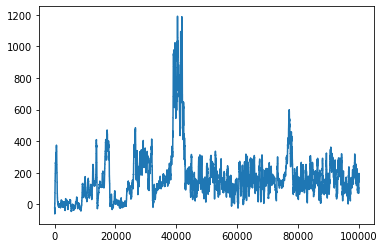

In [70]:
plt.plot(p['EpRewMean'])

In [61]:
# with batch size 16
download_artifact("trpo-pendulum-16-2021-05-10-01-28-32")

==== Walking the artifact dir ====
/home/ubuntu/log/trpo-pendulum-16-2021-05-10-01-28-32 ['ckpt', 'output'] ['model.tar.gz']
/home/ubuntu/log/trpo-pendulum-16-2021-05-10-01-28-32/ckpt [] ['ckpt-1.data-00000-of-00001', 'checkpoint', 'ckpt-1.index']
/home/ubuntu/log/trpo-pendulum-16-2021-05-10-01-28-32/output [] ['log.txt', 'progress.csv', '0.0.monitor.csv']


'/home/ubuntu/log/trpo-pendulum-16-2021-05-10-01-28-32'

    EpLenMean  EpRewMean  EpThisIter  EpisodesSoFar  TimeElapsed  \
12      200.0  265.47552           1              1     1.868902   
13      200.0  265.47552           0              1     1.902575   
14      200.0  265.47552           0              1     1.936753   
15      200.0  265.47552           0              1     1.970603   
16      200.0  265.47552           0              1     2.010642   

    TimestepsSoFar  entloss   entropy  ev_tdlam_before    meankl  optimgain  \
12             200      0.0  1.433668         0.018047  0.001280   0.011800   
13             200      0.0  1.432159        -0.012498  0.000822   0.019121   
14             200      0.0  1.432776         0.024651  0.000552   0.011609   
15             200      0.0  1.430317        -0.001478  0.000447   0.011690   
16             200      0.0  1.424093         0.004339  0.000607   0.026443   

    surrgain  
12  0.011800  
13  0.019121  
14  0.011609  
15  0.011690  
16  0.026443  


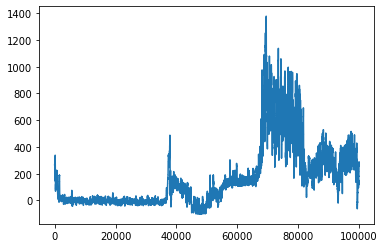

In [74]:
p = get_performance("trpo-pendulum-16-2021-05-10-01-28-32")
plt.plot(p['EpRewMean'])

In [75]:
# with batch size 32
download_artifact("trpo-pendulum-32-2021-05-10-01-28-34")


==== Walking the artifact dir ====
/home/ubuntu/log/trpo-pendulum-32-2021-05-10-01-28-34 ['ckpt', 'output'] ['model.tar.gz']
/home/ubuntu/log/trpo-pendulum-32-2021-05-10-01-28-34/ckpt [] ['ckpt-1.data-00000-of-00001', 'checkpoint', 'ckpt-1.index']
/home/ubuntu/log/trpo-pendulum-32-2021-05-10-01-28-34/output [] ['log.txt', 'progress.csv', '0.0.monitor.csv']


'/home/ubuntu/log/trpo-pendulum-32-2021-05-10-01-28-34'

    EpLenMean  EpRewMean  EpThisIter  EpisodesSoFar  TimeElapsed  \
6       200.0   611.9739           1              1     1.717268   
7       200.0   611.9739           0              1     1.757364   
8       200.0   611.9739           0              1     1.799208   
9       200.0   611.9739           0              1     1.839432   
10      200.0   611.9739           0              1     1.881312   

    TimestepsSoFar  entloss   entropy  ev_tdlam_before    meankl  optimgain  \
6              200      0.0  1.422825        -0.002082  0.001007   0.020219   
7              200      0.0  1.407881         0.003033  0.001037   0.040282   
8              200      0.0  1.404076        -0.004431  0.000318   0.012937   
9              200      0.0  1.412191        -0.008157  0.000605   0.009415   
10             200      0.0  1.409631        -0.017505  0.000348   0.015545   

    surrgain  
6   0.020219  
7   0.040282  
8   0.012937  
9   0.009415  
10  0.015545  


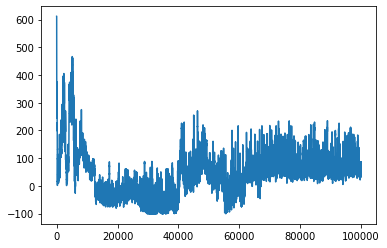

In [77]:
p = get_performance("trpo-pendulum-32-2021-05-10-01-28-34")
plt.plot(p['EpRewMean'])

==== Walking the artifact dir ====
/home/ubuntu/log/trpo-pendulum-64-2021-05-10-01-28-35 ['ckpt', 'output'] ['model.tar.gz']
/home/ubuntu/log/trpo-pendulum-64-2021-05-10-01-28-35/ckpt [] ['ckpt-1.data-00000-of-00001', 'checkpoint', 'ckpt-1.index']
/home/ubuntu/log/trpo-pendulum-64-2021-05-10-01-28-35/output [] ['log.txt', 'progress.csv', '0.0.monitor.csv']
   EpLenMean  EpRewMean  EpThisIter  EpisodesSoFar  TimeElapsed  \
3      200.0  688.53906           1              1     1.861876   
4      200.0  688.53906           0              1     1.926766   
5      200.0  688.53906           0              1     1.992243   
6      200.0  614.09235           1              2     2.060303   
7      200.0  614.09235           0              2     2.145983   

   TimestepsSoFar  entloss   entropy  ev_tdlam_before    meankl  optimgain  \
3             200      0.0  1.369355         0.009717  0.000907   0.021190   
4             200      0.0  1.351841        -0.000324  0.001091   0.015073   
5   

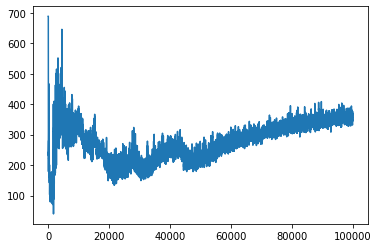

In [81]:
# with batch size 64
tj = "trpo-pendulum-64-2021-05-10-01-28-35"
download_artifact(tj)
p = get_performance(tj)
plt.plot(p['EpRewMean'])

==== Walking the artifact dir ====
/home/ubuntu/log/trpo-pendulum-128-2021-05-10-01-28-36 ['ckpt', 'output'] ['model.tar.gz']
/home/ubuntu/log/trpo-pendulum-128-2021-05-10-01-28-36/ckpt [] ['ckpt-1.data-00000-of-00001', 'checkpoint', 'ckpt-1.index']
/home/ubuntu/log/trpo-pendulum-128-2021-05-10-01-28-36/output [] ['log.txt', 'progress.csv', '0.0.monitor.csv']
   EpLenMean  EpRewMean  EpThisIter  EpisodesSoFar  TimeElapsed  \
1      200.0  602.81060           1              1     2.022326   
2      200.0  602.81060           0              1     2.214307   
3      200.0  288.18256           1              2     2.413919   
4      200.0  190.95805           1              3     2.559805   
5      200.0  190.95805           0              3     2.685597   

   TimestepsSoFar  entloss   entropy  ev_tdlam_before    meankl  optimgain  \
1             200      0.0  1.416195        -0.001885  0.000743   0.017680   
2             200      0.0  1.409104        -0.001039  0.000799   0.007599   
3

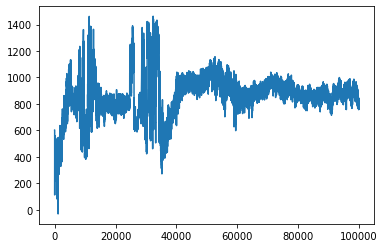

In [31]:
tj = "trpo-pendulum-128-2021-05-10-01-28-36"
download_artifact(tj)
p = get_performance(tj)
plt.plot(p['EpRewMean'])

==== Walking the artifact dir ====
/home/ubuntu/log/trpo-pendulum-256-2021-05-10-01-28-37 ['ckpt', 'output'] ['model.tar.gz']
/home/ubuntu/log/trpo-pendulum-256-2021-05-10-01-28-37/ckpt [] ['ckpt-1.data-00000-of-00001', 'checkpoint', 'ckpt-1.index']
/home/ubuntu/log/trpo-pendulum-256-2021-05-10-01-28-37/output [] ['log.txt', 'progress.csv', '0.0.monitor.csv']
    EpLenMean  EpRewMean  EpThisIter  EpisodesSoFar  TimeElapsed  \
0  200.000000  396.03378           1              1     1.733068   
1  161.333333  343.63538           2              3     1.935284   
2  130.200000  165.97704           2              5     2.129916   
3  141.833333  204.85942           1              6     2.326335   
4  156.375000  270.32275           2              8     2.542688   

   TimestepsSoFar  entloss   entropy  ev_tdlam_before    meankl  optimgain  \
0             200      0.0  1.399326        -0.001810  0.000963   0.012478   
1             484      0.0  1.399443        -0.003958  0.000831   0.00741

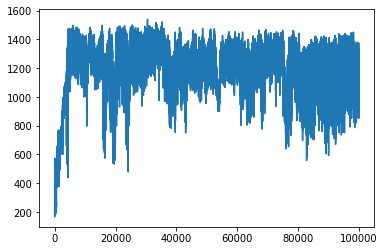

In [32]:
tj = "trpo-pendulum-256-2021-05-10-01-28-37"
download_artifact(tj)
p = get_performance(tj)
plt.plot(p['EpRewMean'])

Heuristically, it looks like bigger batch size makes training a bit more stable. 

Look at how the model behaves for the one trained with batch size 64

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

from baselines.common.models import get_network_builder
from baselines.common.policies import PolicyWithValue
import os
import os.path as osp
import tensorflow as tf
import gym
import numpy as np


def show_state(env, step=0, info=""):
    plt.figure(3)
    plt.clf() # clear current figure
    plt.imshow(env.render(mode='rgb_array'))
    #plt.title("%s | Step: %d %s" % (env._spec.id, step, info))
    plt.axis('off')
    display.clear_output(wait=True)
    display.display(plt.gcf()) # get_current figure
    
    

def inspect_model(training_job_name):
    artifact_dir = os.path.join(os.environ['HOME'], 'log', training_job_name)
    ckpt_dir = os.path.join(artifact_dir, 'ckpt')
    
    env = gym.make('Pendulum-v0')
    env.reset()

    ob_space = env.observation_space
    ac_space = env.action_space

    network='mlp'

    network=get_network_builder(network)(**{})

    # restore policy and value network
    pi_policy_network = network(ob_space.shape)
    pi_value_network = network(ob_space.shape)
    pi = PolicyWithValue(ac_space, pi_policy_network, pi_value_network)
    
    ckpt_dir = osp.expanduser(ckpt_dir)
    ckpt = tf.train.Checkpoint(model=pi)
    manager = tf.train.CheckpointManager(ckpt, ckpt_dir, max_to_keep=None)

    ckpt.restore(manager.latest_checkpoint)
    
    # see actions 
    ob = env.reset()
    total_rew = 0.0
    n = 1000
    for t in range(n):
        show_state(env, t)
        ob = np.expand_dims(ob, axis=0)
        ob = tf.constant(ob)
        ac, *_ = pi.step(ob)
        ob, rew, new, _ = env.step(ac)
        total_rew += rew
    
    # clear the last image
    plt.clf()

    print('total reward: ', total_rew)
    print('avg reward: ', total_rew / n)
    return


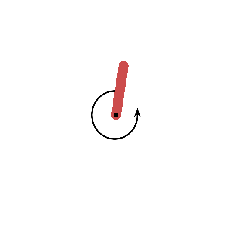

total reward:  [-4061.53]
avg reward:  [-4.06153]


<Figure size 432x288 with 0 Axes>

In [37]:
tj= "trpo-pendulum-256-2021-05-10-01-28-37"
inspect_model(tj)

trpo-pendulum-64-2021-05-10-01-28-35
trpo-pendulum-128-2021-05-10-01-28-36
trpo-pendulum-256-2021-05-10-01-28-37